In [1]:
import pandas as pd
import numpy as np
import ast
!pwd

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

# plt.style.use('QC_publication')
# sns.axes_style("darkgrid")
# This just tells Jupyter to plot our figures as output using the widget
%matplotlib inline 
# if matplotlib widget is not installed (it makes the plot interactive) you can use %matplotlib inline instead for static plots
matplotlib.matplotlib_fname()

/exports/csce/datastore/geos/users/s2135982/rivertools/mlfluv/script


'/exports/csce/datastore/geos/users/s2135982/miniconda/envs/LSDTTtest/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'

In [2]:
data_path = '../exp_data_fixed.csv'

df = pd.read_csv(data_path)

df[['log_num', 'tune_log_num']] = df[['log_num', 'tune_log_num']].astype(int)

# Convert the 'Class wise IoU' column back to list of floats instead of a string
df['Class wise IoU'] = df['Class wise IoU'].apply(ast.literal_eval) 
print(df['Class wise IoU'][1])

# print(df['Class wise IoU'].head(2))

[0.0, 0.9153899427117973, 0.7031360852307287, 0.837030225375603, 0.0, 0.0, 0.45408872468718164]


In [3]:
df.sort_values(by=['log_num', 'tune_log_num', 'distill_lamda', 'temperature'])

,log_num,which_label,weights,tune_log_num,distill_lamda,temperature,Mean IoU,Micro IoU,Macro IoU,Accuracy,Precision,Class wise IoU
1,1001,ESRI,inverse_log,1,0.0,1.0,0.416,0.844,0.411,0.976,0.915,"[0.0, 0.9153899427117973, 0.7031360852307287, ..."
12,1001,ESRI,inverse_log,2,0.0,0.1,0.417,0.842,0.415,0.976,0.914,"[0.0, 0.9121360515726024, 0.6953245169129865, ..."
19,1001,ESRI,inverse_log,3,0.0,0.5,0.444,0.846,0.470,0.976,0.916,"[0.0, 0.9077670208339034, 0.6848213113587478, ..."
20,1001,ESRI,inverse_log,4,0.0,2.0,0.475,0.842,0.484,0.975,0.914,"[0.0, 0.907280026633164, 0.6814200014903627, 0..."
21,1001,ESRI,inverse_log,5,0.0,10.0,0.414,0.835,0.407,0.974,0.910,"[0.0, 0.9042994055254706, 0.6743109920929218, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
144,3002,ESAWC,inverse_count,22,1.0,1.0,0.214,0.638,0.220,0.937,0.779,"[0.0, 0.7392220616340637, 0.012683488835845592..."
145,3002,ESAWC,inverse_count,23,1.0,0.1,0.142,0.583,0.144,0.925,0.737,"[0.0, 0.7094986907367049, 0.06104952320456505,..."
146,3002,ESAWC,inverse_count,24,1.0,0.5,0.171,0.599,0.174,0.928,0.749,"[0.0, 0.7144840577553059, 0.00619892331065032,..."
147,3002,ESAWC,inverse_count,25,1.0,2.0,0.233,0.685,0.243,0.947,0.813,"[0.0, 0.8011895085203237, 0.2519480292139382, ..."


In [4]:
# Define class names and their corresponding indices
class_names = ['tree', 'SR vegetation', 'water', 'urban', 'bare ground', 'fluvial sediment']

# Function to extract IoU values for each class
def extract_iou_values(iou_list):
    result = {}
    for i, class_name in enumerate(class_names, start=1):
        if i < len(iou_list):
            result[class_name] = iou_list[i]
        else:
            result[class_name] = np.nan
    return result

# Apply the function to each row and create new columns
iou_values = df['Class wise IoU'].apply(extract_iou_values)
iou_df = pd.DataFrame(iou_values.tolist())

# Concatenate the original DataFrame with the new columns
df = pd.concat([df, iou_df], axis=1)

In [5]:
# Select rows where 'fluvial sediment' IoU is NaN
init_df = df[df['fluvial sediment'].isna()]

# Update 'tune_log_num' to 0 for these selected rows to represent these models are the initial models
df.loc[init_df.index, 'tune_log_num'] = 0
df.loc[init_df.index, 'temperature'] = 1
df.loc[init_df.index, 'distill_lamda'] = 0

# Check errors in tune log number, temperature and lamda
df_label = df[df['which_label']=='DW'].sort_values(by=['log_num', 'tune_log_num', 'distill_lamda', 'temperature'])
# df_label[['log_num', 'tune_log_num', 'distill_lamda', 'temperature', 'Mean IoU']]


In [6]:
# Fix the tune log number jump from 0 to 2. The correct version should be 0 to 25 continuous intergers
# Check if 1 is missing in the 'tune_log_num' column

def fix_tune_log_jump(log_number:int):
    df_log_number = df[df['log_num'] == log_number]

    if 1 not in df_log_number['tune_log_num'].values:
        # Shift values 2-26 to 1-25 in the filtered dataframe
        df_log_number.loc[df_log_number['tune_log_num'] > 1, 'tune_log_num'] -= 1
        # Update the original dataframe with the modified values
        df.loc[df['log_num'] == log_number, 'tune_log_num'] = df_log_number['tune_log_num']

fix_tune_log_jump(2002)
fix_tune_log_jump(3001)
fix_tune_log_jump(3002)

# Display the dataframe
# print(df[df['log_num']==3001])

In [7]:
# Find best models of both initial train and fine tune
best_miou_idx = df.groupby('which_label')['Mean IoU'].idxmax()
best_mIoU_param = df.loc[best_miou_idx].sort_values(by=['log_num'])
# print(best_model_param)
print(best_mIoU_param[['log_num', 'tune_log_num', 'distill_lamda', 'temperature', 'Mean IoU', 'water', 'bare ground', 'fluvial sediment']])

     log_num  tune_log_num  distill_lamda  temperature  Mean IoU     water  \
26      1002             0            0.0          1.0     0.542  0.835017   
78      2002             0            0.0          1.0     0.464  0.853746   
104     3001             0            0.0          1.0     0.411  0.824797   

     bare ground  fluvial sediment  
26      0.375404               NaN  
78      0.291854               NaN  
104     0.000000               NaN  


In [8]:
# Find best models of fine tune only
# Exclude the initial trained models
filtered_df = df[~df['fluvial sediment'].isna()]

best_miou_idx = filtered_df.groupby('which_label')['Mean IoU'].idxmax()
best_mIoU_param = filtered_df.loc[best_miou_idx].sort_values(by=['log_num'])
# print(best_model_param)
print(best_mIoU_param[['log_num', 'tune_log_num', 'distill_lamda', 'temperature', 'Mean IoU', 'water', 'bare ground', 'fluvial sediment']])

     log_num  tune_log_num  distill_lamda  temperature  Mean IoU     water  \
49      1002             7           0.25          0.1     0.501  0.837815   
100     2002             5           0.00         10.0     0.457  0.836788   
150     3002             3           0.00          0.5     0.371  0.679868   

     bare ground  fluvial sediment  
49      0.000000          0.457098  
100     0.015973          0.476904  
150     0.000000          0.000000  


In [9]:
# Find best models of predicting water. Exclude the initial trained models
best_water_idx = filtered_df.groupby('which_label')['water'].idxmax()
best_water_param = filtered_df.loc[best_water_idx].sort_values(by=['log_num'])
print(best_water_param[['log_num', 'tune_log_num', 'distill_lamda', 'temperature', 'Mean IoU', 'water', 'bare ground', 'fluvial sediment']])

     log_num  tune_log_num  distill_lamda  temperature  Mean IoU     water  \
11      1001            19           0.75          2.0     0.407  0.857322   
73      2001             5           0.00         10.0     0.385  0.840798   
119     3001            22           1.00          0.1     0.333  0.763697   

     bare ground  fluvial sediment  
11           0.0          0.422830  
73           0.0          0.484286  
119          0.0          0.000254  


In [10]:
# Find best models of predicting sediment. Exclude the initial trained models
best_water_idx = df.groupby('which_label')['fluvial sediment'].idxmax()
best_water_param = df.loc[best_water_idx].sort_values(by=['log_num'])
print(best_water_param[['log_num', 'tune_log_num', 'distill_lamda', 'temperature', 'Mean IoU', 'water', 'urban', 'bare ground', 'fluvial sediment']])

     log_num  tune_log_num  distill_lamda  temperature  Mean IoU     water  \
47      1002             5           0.00         10.0     0.452  0.800636   
72      2001             4           0.00          2.0     0.383  0.830407   
142     3002            19           0.75          2.0     0.220  0.471257   

        urban  bare ground  fluvial sediment  
47   0.226746     0.096410          0.551554  
72   0.000000     0.006314          0.488580  
142  0.000000     0.000000          0.016534  


In [11]:
# Find best models of predicting bare ground. Exclude the initial trained models
best_water_idx = filtered_df.groupby('which_label')['bare ground'].idxmax()
best_water_param = filtered_df.loc[best_water_idx].sort_values(by=['log_num'])
print(best_water_param[['log_num', 'tune_log_num', 'distill_lamda', 'temperature', 'Mean IoU', 'water','urban', 'bare ground', 'fluvial sediment']])

     log_num  tune_log_num  distill_lamda  temperature  Mean IoU     water  \
47      1002             5           0.00         10.0     0.452  0.800636   
99      2002             4           0.00          2.0     0.430  0.823298   
143     3002            20           0.75         10.0     0.220  0.594977   

        urban  bare ground  fluvial sediment  
47   0.226746     0.096410          0.551554  
99   0.324462     0.043452          0.328851  
143  0.000000     0.000082          0.000000  


In [12]:
# Find best models of predicting bare ground. Exclude the initial trained models
best_water_idx = filtered_df.groupby('which_label')['bare ground'].idxmax()
best_water_param = filtered_df.loc[best_water_idx].sort_values(by=['log_num'])
print(best_water_param[['log_num', 'tune_log_num', 'distill_lamda', 'temperature', 'Mean IoU', 'water','urban', 'bare ground', 'fluvial sediment']])

     log_num  tune_log_num  distill_lamda  temperature  Mean IoU     water  \
47      1002             5           0.00         10.0     0.452  0.800636   
99      2002             4           0.00          2.0     0.430  0.823298   
143     3002            20           0.75         10.0     0.220  0.594977   

        urban  bare ground  fluvial sediment  
47   0.226746     0.096410          0.551554  
99   0.324462     0.043452          0.328851  
143  0.000000     0.000082          0.000000  


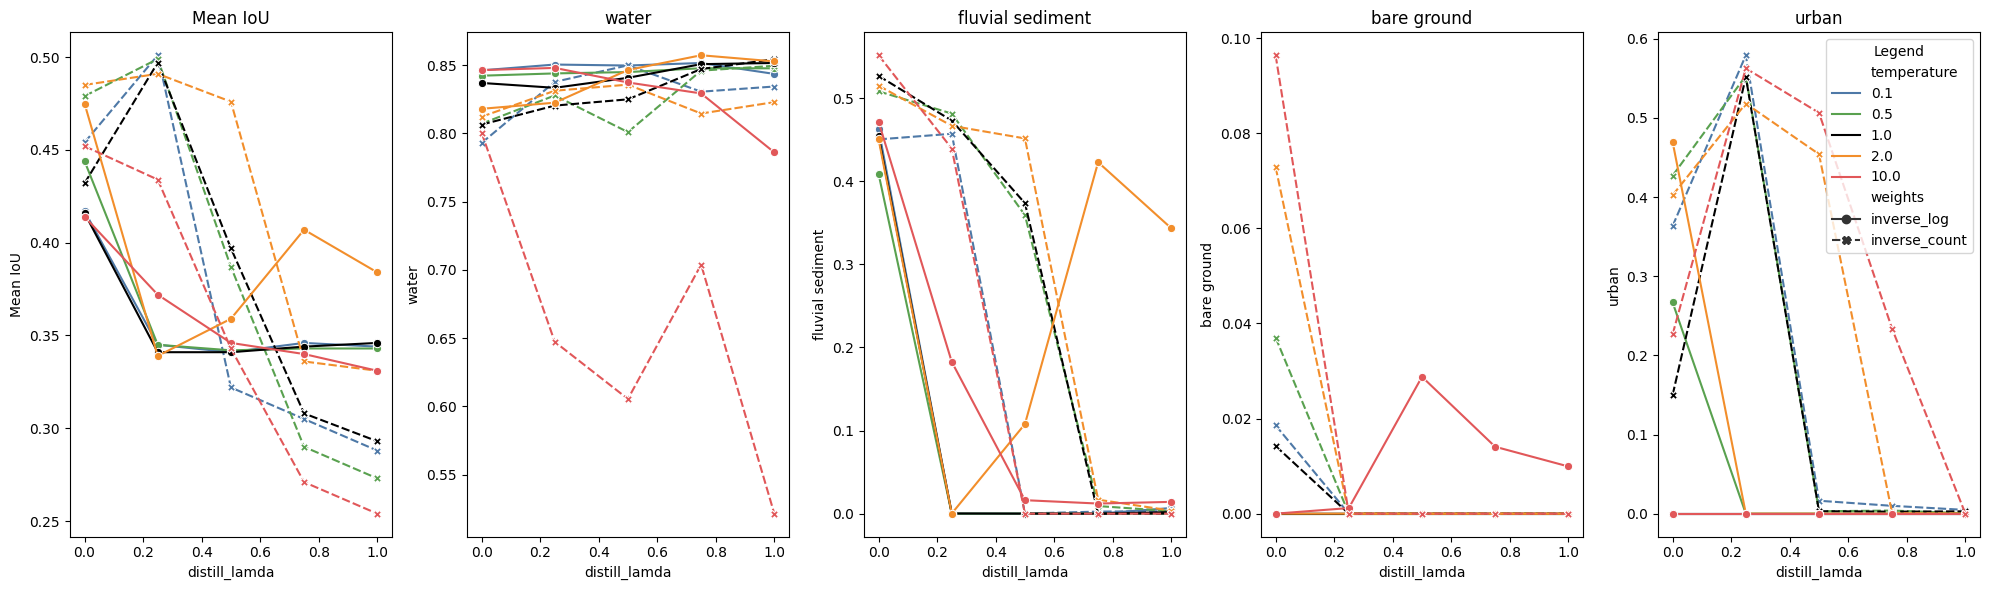

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sub_df = filtered_df[filtered_df['which_label'] == 'ESRI']
df1 = sub_df[sub_df['weights'] == 'inverse_log']
df2 = sub_df[sub_df['weights'] == 'inverse_count']

# Define a custom color palette for 'temperature' categories
temperature_palette = ['#4e79a7', '#59a14f','black', '#f28e2b', '#e15759']
sns.set_palette(temperature_palette)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))

for i, col in enumerate(['Mean IoU', 'water', 'fluvial sediment', 'bare ground','urban']):
    sns.lineplot(data=sub_df, x='distill_lamda', y=col, hue='temperature', style='weights',
                 markers=True, ax=axes[i], palette=temperature_palette)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('distill_lamda')
    axes[i].set_ylabel(col)
    axes[i].legend().set_visible(False)  # Remove individual legends

# Create a common legend outside the subplots
handles, labels = axes[0].get_legend_handles_labels()
plt.legend(handles, labels, title='Legend', loc='upper right')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
